In [2]:
# -*- coding: utf-8 -*-
"""train_classifier_memory_optimized

Memory-optimized version for road damage classification with 4-channel input
"""

from google.colab import drive
drive.mount('/content/drive')

# Road Damage Multi-Head Classifier Training with 4-Channel Input (Memory Optimized)
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
import gc
warnings.filterwarnings('ignore')

# =============================================================================
# MEMORY-OPTIMIZED GPU CONFIGURATION
# =============================================================================

print("Configuring GPU with memory optimization...")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:




        # Use mixed precision for memory efficiency
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print(f"Mixed precision enabled: {policy.name}")

        print(f"GPU configured with memory limit")

    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPU found, using CPU")

# Clear any existing graphs
tf.keras.backend.clear_session()
gc.collect()

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# =============================================================================
# 1. DATA LOADING AND EXPLORATION
# =============================================================================

# Load labels
with open('/content/drive/MyDrive/road_damage_project/distance_labels.json', 'r') as f:
    labels_data = json.load(f)

image_dir = '/content/drive/MyDrive/road_damage_project/distance_images/'
heatmap_dir = '/content/drive/MyDrive/road_damage_project/distance_heatmaps_numpy/'

print(f"Total samples: {len(labels_data)}")

# Convert to DataFrame and immediately optimize memory
df = pd.DataFrame(labels_data)

# Handle null severity values
df['severity'] = df['severity'].fillna('none')

# Optimize DataFrame memory usage
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

print("Dataset loaded and optimized")

# =============================================================================
# 2. MEMORY-OPTIMIZED DATA PREPROCESSING
# =============================================================================

def sample_evenly_distributed(df, target_total_samples=150):  # Reduced sample size
    """Sample DataFrame with smaller target for memory efficiency"""
    num_damage_classes = len(df['damage_type'].unique())
    target_samples_per_class = max(1, target_total_samples // num_damage_classes)

    sampled_df = pd.DataFrame()
    for damage_type in df['damage_type'].unique():
        class_df = df[df['damage_type'] == damage_type]
        n_samples = min(len(class_df), target_samples_per_class)
        sampled_class_df = class_df.sample(n=n_samples, random_state=42)
        sampled_df = pd.concat([sampled_df, sampled_class_df])

    if len(sampled_df) > target_total_samples:
         sampled_df = sampled_df.sample(n=target_total_samples, random_state=42)

    return sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Use smaller sample size to fit in memory
# df_sampled = sample_evenly_distributed(df, target_total_samples=1300)
df_clean = df

print(f"Using {len(df_clean)} samples for memory optimization")

# Encode labels
damage_type_encoder = LabelEncoder()
severity_encoder = LabelEncoder()

df_clean['damage_type_encoded'] = damage_type_encoder.fit_transform(df_clean['damage_type'])
df_clean['severity_encoded'] = severity_encoder.fit_transform(df_clean['severity'])

num_damage_classes = len(damage_type_encoder.classes_)
num_severity_classes = len(severity_encoder.classes_)

print(f"Damage classes: {num_damage_classes}, Severity classes: {num_severity_classes}")

# Clean up
del df, labels_data
gc.collect()

# =============================================================================
# 3. MEMORY-EFFICIENT IMAGE LOADING
# =============================================================================

def load_image_efficient(image_path, target_size=(360, 450)):  # Reduced size
    """Load image with reduced resolution for memory efficiency"""
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size, Image.LANCZOS)  # Better quality resize
        img_array = np.array(img, dtype=np.float16) / 255.0  # Use float16
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def load_heatmap_efficient(heatmap_path, target_size=(360, 450)):  # Reduced size
    """Load heatmap with reduced resolution"""
    try:
        data = np.load(heatmap_path)
        heatmap = data[list(data.keys())[0]]

        # Transpose if heatmap is in (height, width)
        if heatmap.shape[0] > heatmap.shape[1]:  # assuming height > width = needs transpose
            heatmap = np.transpose(heatmap, (1, 0))  # (h, w) → (w, h)

        # Resize: cv2 expects (width, height)
        if heatmap.shape[:2] != target_size:
            heatmap = cv2.resize(heatmap, target_size)  # target_size = (width, height)

        # Normalize and convert
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        heatmap = heatmap.astype(np.float16)

        # Ensure shape is (width, height, 1)
        if len(heatmap.shape) == 2:
            heatmap = np.expand_dims(heatmap, axis=-1)

        return heatmap
    except Exception as e:
        print(f"Error loading heatmap {heatmap_path}: {e}")
        return None

# =============================================================================
# 4. MEMORY-EFFICIENT DATASET GENERATOR
# =============================================================================

class MemoryEfficientDataGenerator(tf.keras.utils.Sequence):
    """Custom data generator to avoid loading all data into memory"""

    def __init__(self, df, image_dir, heatmap_dir, batch_size=8, target_size=(360, 450),
                 num_damage_classes=None, num_severity_classes=None, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.heatmap_dir = heatmap_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_damage_classes = num_damage_classes
        self.num_severity_classes = num_severity_classes
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y = self._generate_batch(batch_indices)
        return batch_x, batch_y

    def _generate_batch(self, batch_indices):
        batch_images = []
        batch_damage = []
        batch_severity = []

        for idx in batch_indices:
            row = self.df.iloc[idx]

            # Load image
            image_path = os.path.join(self.image_dir, row['image_name'])
            img = load_image_efficient(image_path, self.target_size)
            if img is None:
                continue

            # Load heatmap
            heatmap_name = f"distance_heatmap_{row['frame_number']}_{row['timestamp']}.npz".replace(".jpg","")
            heatmap_path = os.path.join(self.heatmap_dir, heatmap_name)
            heatmap = load_heatmap_efficient(heatmap_path, self.target_size)
            if heatmap is None:
                continue

            # Combine
            combined = np.concatenate([img, heatmap], axis=-1)

            batch_images.append(combined)
            batch_damage.append(row['damage_type_encoded'])
            batch_severity.append(row['severity_encoded'])

        if len(batch_images) == 0:
            return None, None

        # Convert to arrays
        batch_x = np.array(batch_images, dtype=np.float32)

        # Convert labels to categorical
        batch_damage_cat = tf.keras.utils.to_categorical(batch_damage, self.num_damage_classes)
        batch_severity_cat = tf.keras.utils.to_categorical(batch_severity, self.num_severity_classes)

        batch_y = {
            'damage_type': batch_damage_cat,
            'severity': batch_severity_cat
        }

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Split data
train_df, temp_df = train_test_split(df_clean, test_size=0.4, random_state=42,
                                    stratify=df_clean['damage_type_encoded'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42,
                                  stratify=temp_df['damage_type_encoded'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Create generators with small batch sizes
BATCH_SIZE = 8  # Very small batch size to fit in memory
TARGET_SIZE = (360, 450)  # Reduced image size

train_generator = MemoryEfficientDataGenerator(
    train_df, image_dir, heatmap_dir, BATCH_SIZE, TARGET_SIZE,
    num_damage_classes, num_severity_classes, shuffle=True
)

val_generator = MemoryEfficientDataGenerator(
    val_df, image_dir, heatmap_dir, BATCH_SIZE, TARGET_SIZE,
    num_damage_classes, num_severity_classes, shuffle=False
)

# =============================================================================
# 5. LIGHTWEIGHT MODEL ARCHITECTURE
# =============================================================================

def create_lightweight_model(input_shape, num_damage_classes, num_severity_classes):
    """Create a lighter model that uses less memory"""

    inputs = layers.Input(shape=input_shape, dtype=tf.float32)

    # Much lighter feature extraction
    x = layers.Conv2D(32, 7, strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Lighter dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output heads
    damage_branch = layers.Dense(64, activation='relu', name='damage_dense')(x)
    damage_branch = layers.Dropout(0.3)(damage_branch)
    damage_branch = layers.Dense(num_damage_classes, name='damage_type_dense')(damage_branch)
    damage_branch = layers.Activation('softmax', dtype='float32', name="damage_type")(damage_branch)

    severity_branch = layers.Dense(64, activation='relu', name='severity_dense')(x)
    severity_branch = layers.Dropout(0.3)(severity_branch)
    severity_branch = layers.Dense(num_severity_classes, name='severity_rating_dense')(severity_branch)
    severity_branch = layers.Activation('softmax', dtype='float32', name="severity")(severity_branch)

    model = keras.Model(inputs=inputs, outputs=[damage_branch, severity_branch])
    return model

# Create lightweight model
input_shape = (450, 360, 4)  # 4 channels
print(f"Input shape: {input_shape}")

model = create_lightweight_model(input_shape, num_damage_classes, num_severity_classes)
model.summary()

print(f"Total parameters: {model.count_params():,}")

# =============================================================================
# 6. MEMORY-OPTIMIZED TRAINING SETUP
# =============================================================================

# Use smaller learning rate for stability
optimizer = keras.optimizers.Adam(learning_rate=0.0005, epsilon=1e-4)

model.compile(
    optimizer=optimizer,
    loss={
        'damage_type': 'categorical_crossentropy',
        'severity': 'categorical_crossentropy'
    },
    loss_weights={'damage_type': 1.0, 'severity': 1.0},
    metrics={
        'damage_type': ['accuracy'],
        'severity': ['accuracy']
    }
)

# Memory-efficient callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_road_damage_lightweight.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Add memory cleanup callback
    keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: gc.collect()
    )
]

# =============================================================================
# 7. MEMORY-EFFICIENT TRAINING
# =============================================================================

print("Starting memory-optimized training...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Image size: {TARGET_SIZE}")
print(f"Model parameters: {model.count_params():,}")

# Train with generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# Clear memory after training
gc.collect()

# =============================================================================
# 8. MEMORY-EFFICIENT EVALUATION
# =============================================================================

print("Evaluating model...")

# Create test generator
test_generator = MemoryEfficientDataGenerator(
    test_df, image_dir, heatmap_dir, BATCH_SIZE, TARGET_SIZE,
    num_damage_classes, num_severity_classes, shuffle=False
)

# Evaluate in batches to save memory
test_results = model.evaluate(test_generator, verbose=1)

print(f"\nTest Results:")
print(f"Overall Loss: {test_results[0]:.4f}")
print(f"Damage Type Loss: {test_results[1]:.4f}")
print(f"Severity Loss: {test_results[2]:.4f}")
print(f"Damage Type Accuracy: {test_results[3]:.4f}")
print(f"Severity Accuracy: {test_results[4]:.4f}")

# =============================================================================
# 9. MEMORY-EFFICIENT PREDICTIONS
# =============================================================================

def get_predictions_in_batches(model, generator):
    """Get predictions in small batches to avoid memory issues"""
    all_damage_preds = []
    all_severity_preds = []
    all_damage_true = []
    all_severity_true = []

    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        if batch_x is not None:
            preds = model.predict(batch_x, verbose=0)

            all_damage_preds.extend(preds[0])
            all_severity_preds.extend(preds[1])
            all_damage_true.extend(np.argmax(batch_y['damage_type'], axis=1))
            all_severity_true.extend(np.argmax(batch_y['severity'], axis=1))

    return (np.array(all_damage_preds), np.array(all_severity_preds),
            np.array(all_damage_true), np.array(all_severity_true))

print("Getting predictions in batches...")
damage_pred, severity_pred, y_damage_true, y_severity_true = get_predictions_in_batches(model, test_generator)

y_damage_pred = np.argmax(damage_pred, axis=1)
y_severity_pred = np.argmax(severity_pred, axis=1)

# =============================================================================
# 10. EVALUATION METRICS
# =============================================================================

print("\n" + "="*50)
print("DAMAGE TYPE CLASSIFICATION REPORT")
print("="*50)
print(classification_report(
    y_damage_true, y_damage_pred,
    target_names=damage_type_encoder.classes_
))

print("\n" + "="*50)
print("SEVERITY CLASSIFICATION REPORT")
print("="*50)
print(classification_report(
    y_severity_true, y_severity_pred,
    target_names=severity_encoder.classes_
))

# =============================================================================
# 11. SAVE MODEL
# =============================================================================

model.save('road_damage_memory_optimized.h5')
print("Memory-optimized model saved")

# Save encoders
import pickle
with open('damage_type_encoder.pkl', 'wb') as f:
    pickle.dump(damage_type_encoder, f)
with open('severity_encoder.pkl', 'wb') as f:
    pickle.dump(severity_encoder, f)

# =============================================================================
# 12. MEMORY USAGE SUMMARY
# =============================================================================

print("\n" + "="*60)
print("MEMORY-OPTIMIZED TRAINING COMPLETE!")
print("="*60)
print(f"Final Test Accuracy - Damage Type: {test_results[3]:.4f}")
print(f"Final Test Accuracy - Severity: {test_results[4]:.4f}")
print(f"Batch Size Used: {BATCH_SIZE}")
print(f"Image Size Used: {TARGET_SIZE}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Samples Used: {len(df_clean)}")
print("Memory optimizations applied:")
print("- Reduced image resolution")
print("- Smaller batch sizes")
print("- Data generators instead of loading all data")
print("- Lightweight model architecture")
print("- Mixed precision training")
print("- Memory cleanup callbacks")
print("="*60)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Configuring GPU with memory optimization...
Mixed precision enabled: mixed_float16
GPU configured with memory limit
TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Total samples: 1534
Dataset loaded and optimized
Using 1534 samples for memory optimization
Damage classes: 9, Severity classes: 4
Train: 920, Val: 307, Test: 307
Input shape: (450, 360, 4)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 450, 360,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 225, 180,  │      6,304 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 225, 180,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 90,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 45,    │     51,264 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 45,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 22,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 11,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 11,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 5, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 3, 256) │    295,168 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 3, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ damage_dense        │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 544,557 (2.08 MB)

 Trainable params: 543,597 (2.07 MB)

 Non-trainable params: 960 (3.75 KB)

Total parameters: 544,557
Starting memory-optimized training...
Batch size: 8
Image size: (360, 450)
Model parameters: 544,557
Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - damage_type_accuracy: 0.1806 - damage_type_loss: 2.1408 - loss: 3.4676 - severity_accuracy: 0.3485 - severity_loss: 1.3268
Epoch 1: val_loss improved from inf to 3.17356, saving model to best_road_damage_lightweight.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 361s 3s/step - damage_type_accuracy: 0.1813 - damage_type_loss: 2.1398 - loss: 3.4665 - severity_accuracy: 0.3485 - severity_loss: 1.3267 - val_damage_type_accuracy: 0.3355 - val_damage_type_loss: 1.8890 - val_loss: 3.1736 - val_severity_accuracy: 0.3322 - val_severity_loss: 1.2704 - learning_rate: 5.0000e-04
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - damage_type_accuracy: 0.3182 - damage_type_loss: 1.8554 - loss: 3.1161 - severity_accuracy: 0.3589 - severity_loss: 1.2607
Epoch 2: val_loss improved from 3.17356 to 3.07657, saving model to best_road_damage_lightweight.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 97s 622ms/step - damage_type_accuracy: 0.3182 - damage_type_loss: 1.8553 - loss: 3.1161 - severity_accuracy: 0.3589 - severity_loss: 1.2607 - val_damage_type_accuracy: 0.3192 - val_damage_type_loss: 1.8081 - val_loss: 3.0766 - val_severity_accuracy: 0.3583 - val_severity_loss: 1.2591 - learning_rate: 5.0000e-04
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - damage_type_accuracy: 0.3583 - damage_type_loss: 1.7625 - loss: 2.9977 - severity_accuracy: 0.3478 - severity_loss: 1.2352
Epoch 3: val_loss did not improve from 3.07657
115/115 ━━━━━━━━━━━━━━━━━━━━ 71s 620ms/step - damage_type_accuracy: 0.3580 - damage_type_loss: 1.7628 - loss: 2.9978 - severity_accuracy: 0.3480 - severity_loss: 1.2350 - val_damage_type_accuracy: 0.3355 - val_damage_type_loss: 1.8299 - val_loss: 3.1966 - val_severity_accuracy: 0.3550 - val_severity_loss: 1.3450 - learning_rate: 5.0000e-04
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - damage_type_accuracy: 0.3236 - dam

115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 624ms/step - damage_type_accuracy: 0.3237 - damage_type_loss: 1.7376 - loss: 2.9516 - severity_accuracy: 0.4305 - severity_loss: 1.2141 - val_damage_type_accuracy: 0.3029 - val_damage_type_loss: 1.7314 - val_loss: 3.0062 - val_severity_accuracy: 0.3811 - val_severity_loss: 1.2734 - learning_rate: 5.0000e-04
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - damage_type_accuracy: 0.3722 - damage_type_loss: 1.6447 - loss: 2.8582 - severity_accuracy: 0.3971 - severity_loss: 1.2135
Epoch 5: val_loss did not improve from 3.00624
115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 631ms/step - damage_type_accuracy: 0.3721 - damage_type_loss: 1.6451 - loss: 2.8587 - severity_accuracy: 0.3971 - severity_loss: 1.2137 - val_damage_type_accuracy: 0.1987 - val_damage_type_loss: 2.0249 - val_loss: 3.3114 - val_severity_accuracy: 0.4169 - val_severity_loss: 1.2847 - learning_rate: 5.0000e-04
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - damage_type_accuracy: 0.3619 - dam

115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 610ms/step - damage_type_accuracy: 0.4737 - damage_type_loss: 1.4187 - loss: 2.5233 - severity_accuracy: 0.4845 - severity_loss: 1.1046 - val_damage_type_accuracy: 0.3779 - val_damage_type_loss: 1.4815 - val_loss: 2.6469 - val_severity_accuracy: 0.4528 - val_severity_loss: 1.1586 - learning_rate: 2.5000e-04
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - damage_type_accuracy: 0.4734 - damage_type_loss: 1.3894 - loss: 2.4425 - severity_accuracy: 0.5176 - severity_loss: 1.0530
Epoch 11: val_loss improved from 2.64688 to 2.62572, saving model to best_road_damage_lightweight.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 606ms/step - damage_type_accuracy: 0.4735 - damage_type_loss: 1.3895 - loss: 2.4427 - severity_accuracy: 0.5174 - severity_loss: 1.0531 - val_damage_type_accuracy: 0.4560 - val_damage_type_loss: 1.4192 - val_loss: 2.6257 - val_severity_accuracy: 0.4658 - val_severity_loss: 1.1796 - learning_rate: 2.5000e-04
Epoch 12/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - damage_type_accuracy: 0.4896 - damage_type_loss: 1.2910 - loss: 2.3158 - severity_accuracy: 0.5234 - severity_loss: 1.0248
Epoch 12: val_loss did not improve from 2.62572
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 605ms/step - damage_type_accuracy: 0.4895 - damage_type_loss: 1.2915 - loss: 2.3165 - severity_accuracy: 0.5233 - severity_loss: 1.0250 - val_damage_type_accuracy: 0.4072 - val_damage_type_loss: 1.5357 - val_loss: 2.7007 - val_severity_accuracy: 0.4463 - val_severity_loss: 1.1459 - learning_rate: 2.5000e-04
Epoch 13/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - damage_type_accuracy: 0.5184 - 

115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 625ms/step - damage_type_accuracy: 0.5183 - damage_type_loss: 1.2840 - loss: 2.3015 - severity_accuracy: 0.5630 - severity_loss: 1.0175 - val_damage_type_accuracy: 0.4332 - val_damage_type_loss: 1.4896 - val_loss: 2.6201 - val_severity_accuracy: 0.4723 - val_severity_loss: 1.1161 - learning_rate: 2.5000e-04
Epoch 14/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - damage_type_accuracy: 0.5701 - damage_type_loss: 1.1943 - loss: 2.1605 - severity_accuracy: 0.5676 - severity_loss: 0.9662
Epoch 14: val_loss did not improve from 2.62007
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 603ms/step - damage_type_accuracy: 0.5699 - damage_type_loss: 1.1945 - loss: 2.1609 - severity_accuracy: 0.5675 - severity_loss: 0.9664 - val_damage_type_accuracy: 0.4560 - val_damage_type_loss: 1.7924 - val_loss: 3.2541 - val_severity_accuracy: 0.4300 - val_severity_loss: 1.4138 - learning_rate: 2.5000e-04
Epoch 15/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - damage_type_accuracy: 0.5635 - 

115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 603ms/step - damage_type_accuracy: 0.6017 - damage_type_loss: 1.1513 - loss: 2.0831 - severity_accuracy: 0.5914 - severity_loss: 0.9318 - val_damage_type_accuracy: 0.3941 - val_damage_type_loss: 1.4402 - val_loss: 2.5359 - val_severity_accuracy: 0.5309 - val_severity_loss: 1.0728 - learning_rate: 2.5000e-04
Epoch 17/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - damage_type_accuracy: 0.6155 - damage_type_loss: 1.0952 - loss: 1.9912 - severity_accuracy: 0.6184 - severity_loss: 0.8959
Epoch 17: val_loss did not improve from 2.53594
115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 607ms/step - damage_type_accuracy: 0.6154 - damage_type_loss: 1.0954 - loss: 1.9914 - severity_accuracy: 0.6183 - severity_loss: 0.8960 - val_damage_type_accuracy: 0.2997 - val_damage_type_loss: 2.0301 - val_loss: 3.3417 - val_severity_accuracy: 0.4528 - val_severity_loss: 1.2943 - learning_rate: 2.5000e-04
Epoch 18/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - damage_type_accuracy: 0.6109 - 

115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 629ms/step - damage_type_accuracy: 0.6109 - damage_type_loss: 1.1159 - loss: 2.0169 - severity_accuracy: 0.6157 - severity_loss: 0.9010 - val_damage_type_accuracy: 0.5309 - val_damage_type_loss: 1.2122 - val_loss: 2.2088 - val_severity_accuracy: 0.5928 - val_severity_loss: 0.9717 - learning_rate: 2.5000e-04
Epoch 19/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - damage_type_accuracy: 0.6327 - damage_type_loss: 1.0074 - loss: 1.8217 - severity_accuracy: 0.6374 - severity_loss: 0.8144
Epoch 19: val_loss did not improve from 2.20881
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 599ms/step - damage_type_accuracy: 0.6326 - damage_type_loss: 1.0078 - loss: 1.8225 - severity_accuracy: 0.6374 - severity_loss: 0.8147 - val_damage_type_accuracy: 0.5147 - val_damage_type_loss: 1.2912 - val_loss: 2.4608 - val_severity_accuracy: 0.5472 - val_severity_loss: 1.1382 - learning_rate: 2.5000e-04
Epoch 20/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - damage_type_accuracy: 0.6264 - 

115/115 ━━━━━━━━━━━━━━━━━━━━ 68s 591ms/step - damage_type_accuracy: 0.6484 - damage_type_loss: 0.9791 - loss: 1.7872 - severity_accuracy: 0.6938 - severity_loss: 0.8080 - val_damage_type_accuracy: 0.5603 - val_damage_type_loss: 1.1985 - val_loss: 2.1709 - val_severity_accuracy: 0.6254 - val_severity_loss: 0.9389 - learning_rate: 2.5000e-04
Epoch 22/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - damage_type_accuracy: 0.6779 - damage_type_loss: 0.8595 - loss: 1.6149 - severity_accuracy: 0.6584 - severity_loss: 0.7554
Epoch 22: val_loss did not improve from 2.17086
115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 611ms/step - damage_type_accuracy: 0.6778 - damage_type_loss: 0.8600 - loss: 1.6155 - severity_accuracy: 0.6584 - severity_loss: 0.7555 - val_damage_type_accuracy: 0.3616 - val_damage_type_loss: 2.1663 - val_loss: 3.8522 - val_severity_accuracy: 0.3941 - val_severity_loss: 1.6589 - learning_rate: 2.5000e-04
Epoch 23/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - damage_type_accuracy: 0.6676 - 

115/115 ━━━━━━━━━━━━━━━━━━━━ 71s 619ms/step - damage_type_accuracy: 0.7013 - damage_type_loss: 0.8271 - loss: 1.4914 - severity_accuracy: 0.7366 - severity_loss: 0.6643 - val_damage_type_accuracy: 0.5896 - val_damage_type_loss: 1.1406 - val_loss: 2.0507 - val_severity_accuracy: 0.6287 - val_severity_loss: 0.8808 - learning_rate: 2.5000e-04
Epoch 25/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - damage_type_accuracy: 0.7112 - damage_type_loss: 0.8497 - loss: 1.5479 - severity_accuracy: 0.7294 - severity_loss: 0.6982
Epoch 25: val_loss did not improve from 2.05069
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 603ms/step - damage_type_accuracy: 0.7110 - damage_type_loss: 0.8501 - loss: 1.5485 - severity_accuracy: 0.7293 - severity_loss: 0.6984 - val_damage_type_accuracy: 0.5114 - val_damage_type_loss: 1.6318 - val_loss: 3.1806 - val_severity_accuracy: 0.4397 - val_severity_loss: 1.5334 - learning_rate: 2.5000e-04
Epoch 26/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - damage_type_accuracy: 0.7208 - 

115/115 ━━━━━━━━━━━━━━━━━━━━ 82s 611ms/step - damage_type_accuracy: 0.7415 - damage_type_loss: 0.7214 - loss: 1.2814 - severity_accuracy: 0.7791 - severity_loss: 0.5600 - val_damage_type_accuracy: 0.6906 - val_damage_type_loss: 0.9732 - val_loss: 1.7304 - val_severity_accuracy: 0.7264 - val_severity_loss: 0.7344 - learning_rate: 1.2500e-04
Epoch 31/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - damage_type_accuracy: 0.7707 - damage_type_loss: 0.6356 - loss: 1.0966 - severity_accuracy: 0.8264 - severity_loss: 0.4610
Epoch 31: val_loss improved from 1.73041 to 1.63283, saving model to best_road_damage_lightweight.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 82s 608ms/step - damage_type_accuracy: 0.7708 - damage_type_loss: 0.6353 - loss: 1.0962 - severity_accuracy: 0.8264 - severity_loss: 0.4608 - val_damage_type_accuracy: 0.7329 - val_damage_type_loss: 0.9094 - val_loss: 1.6328 - val_severity_accuracy: 0.7492 - val_severity_loss: 0.6990 - learning_rate: 1.2500e-04
Epoch 32/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - damage_type_accuracy: 0.7863 - damage_type_loss: 0.6166 - loss: 1.0883 - severity_accuracy: 0.8221 - severity_loss: 0.4717
Epoch 32: val_loss did not improve from 1.63283
115/115 ━━━━━━━━━━━━━━━━━━━━ 72s 628ms/step - damage_type_accuracy: 0.7864 - damage_type_loss: 0.6164 - loss: 1.0879 - severity_accuracy: 0.8221 - severity_loss: 0.4715 - val_damage_type_accuracy: 0.6580 - val_damage_type_loss: 1.0025 - val_loss: 1.7285 - val_severity_accuracy: 0.7166 - val_severity_loss: 0.6990 - learning_rate: 1.2500e-04
Epoch 33/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - damage_type_accuracy: 0.8355 - 

115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 614ms/step - damage_type_accuracy: 0.7851 - damage_type_loss: 0.5757 - loss: 0.9480 - severity_accuracy: 0.8636 - severity_loss: 0.3723 - val_damage_type_accuracy: 0.7134 - val_damage_type_loss: 0.9303 - val_loss: 1.6254 - val_severity_accuracy: 0.7655 - val_severity_loss: 0.6699 - learning_rate: 1.2500e-04
Epoch 36/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - damage_type_accuracy: 0.8077 - damage_type_loss: 0.5385 - loss: 0.9241 - severity_accuracy: 0.8566 - severity_loss: 0.3855
Epoch 36: val_loss did not improve from 1.62536
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 598ms/step - damage_type_accuracy: 0.8078 - damage_type_loss: 0.5384 - loss: 0.9238 - severity_accuracy: 0.8566 - severity_loss: 0.3855 - val_damage_type_accuracy: 0.7101 - val_damage_type_loss: 1.0043 - val_loss: 1.9315 - val_severity_accuracy: 0.7296 - val_severity_loss: 0.8965 - learning_rate: 1.2500e-04
Epoch 37/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - damage_type_accuracy: 0.8563 - 

115/115 ━━━━━━━━━━━━━━━━━━━━ 84s 610ms/step - damage_type_accuracy: 0.9109 - damage_type_loss: 0.2710 - loss: 0.4780 - severity_accuracy: 0.9247 - severity_loss: 0.2069 - val_damage_type_accuracy: 0.7785 - val_damage_type_loss: 0.8814 - val_loss: 1.5848 - val_severity_accuracy: 0.8339 - val_severity_loss: 0.6782 - learning_rate: 3.1250e-05
Restoring model weights from the end of the best epoch: 50.
Evaluating model...
39/39 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - damage_type_accuracy: 0.7651 - damage_type_loss: 1.0570 - loss: 1.6082 - severity_accuracy: 0.8268 - severity_loss: 0.5499

Test Results:
Overall Loss: 1.5577
Damage Type Loss: 0.9590
Severity Loss: 0.5743
Damage Type Accuracy: 0.7883
Severity Accuracy: 0.8241
Getting predictions in batches...



DAMAGE TYPE CLASSIFICATION REPORT
                  precision    recall  f1-score   support

 alligator crack       0.68      0.91      0.78        54
     block crack       0.67      0.48      0.56        21
    corner break       0.83      0.73      0.77        33
  diagonal crack       0.72      1.00      0.84        18
       good road       0.94      0.85      0.89       104
horizontal crack       0.76      0.79      0.77        56
         pothole       0.00      0.00      0.00         2
  slippage crack       0.64      0.60      0.62        15
  vertical crack       0.00      0.00      0.00         4

        accuracy                           0.79       307
       macro avg       0.58      0.59      0.58       307
    weighted avg       0.78      0.79      0.78       307


SEVERITY CLASSIFICATION REPORT
              precision    recall  f1-score   support

        high       0.42      0.38      0.40        13
         low       0.83      0.86      0.84       110
      medium 

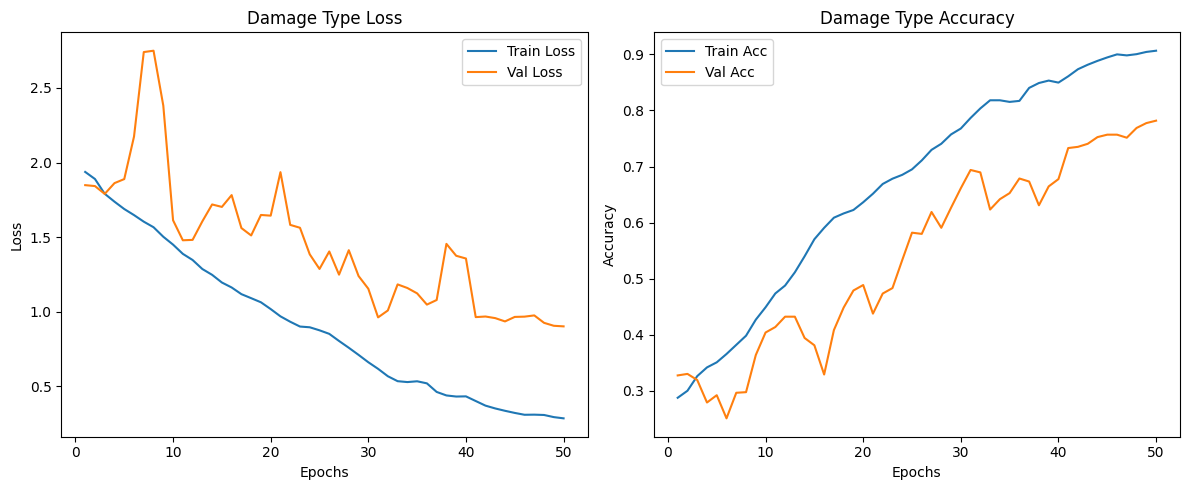

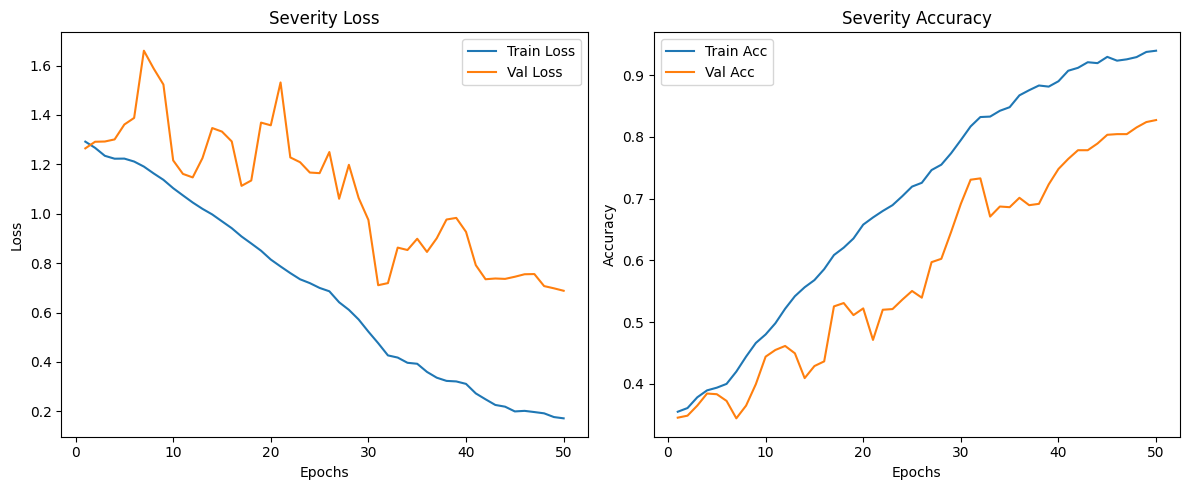

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def smooth(values, window=3):
    return pd.Series(values).rolling(window, min_periods=1, center=True).mean()

def plot_training_history(history):
    """Plots the smoothed training and validation loss and accuracy for both outputs."""
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    # Damage Type
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, smooth(history_dict['damage_type_loss']), label='Train Loss')
    plt.plot(epochs, smooth(history_dict['val_damage_type_loss']), label='Val Loss')
    plt.title('Damage Type Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, smooth(history_dict['damage_type_accuracy']), label='Train Acc')
    plt.plot(epochs, smooth(history_dict['val_damage_type_accuracy']), label='Val Acc')
    plt.title('Damage Type Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Severity
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, smooth(history_dict['severity_loss']), label='Train Loss')
    plt.plot(epochs, smooth(history_dict['val_severity_loss']), label='Val Loss')
    plt.title('Severity Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, smooth(history_dict['severity_accuracy']), label='Train Acc')
    plt.plot(epochs, smooth(history_dict['val_severity_accuracy']), label='Val Acc')
    plt.title('Severity Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_training_history(history)
#